In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl

In [3]:
import PixelCNN as pcnn

In [4]:
mnist_dataset = torchvision.datasets.MNIST(
    root="/home/julian/ImageDataSets/MNIST",
    train = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: (x > 0.5).float()),
    ]))

In [5]:
mnist_train, mnist_val = torch.utils.data.random_split(mnist_dataset, [55000, 5000])
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=32)

In [6]:
def sample():
    sampl = torch.zeros( (1,1,28,28), device="cuda")
    h = nn.functional.one_hot(torch.randint(low=0,high=9,size=[1]),10).type(torch.float).to("cuda")
    for y in range(28):
        for x in range(28):
            params = mymodel.model(sampl, h)
            sampl[0,0,y,x] = torch.distributions.Bernoulli(logits=params[0,0,y,x]).sample()
    return sampl

In [7]:
class LitPixelCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = pcnn.PixelCNN(num_input_channels=1, kernel_size=5, num_distribution_params=1, num_conditional_channels=10)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        global mymodel
        x, y = train_batch
        h = nn.functional.one_hot(y,10).type(torch.float)
        log_prob = torch.distributions.Independent(torch.distributions.Bernoulli(logits=self.model(x, h)), reinterpreted_batch_ndims=3).log_prob(x)
        loss = -log_prob
        mean_loss = torch.mean(loss)
        self.log('train_loss', mean_loss)
        return mean_loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        h = nn.functional.one_hot(y,10).type(torch.float)
        log_prob = torch.distributions.Independent(torch.distributions.Bernoulli(logits=self.model(x, h)), reinterpreted_batch_ndims=3).log_prob(x)
        loss = -log_prob
        mean_loss = torch.mean(loss)
        self.log('val_loss', mean_loss)
        
    def validation_epoch_end(self, val_step_outputs):
        imglist = [sample()[0] for _ in range(16)]
        self.logger.experiment.add_image("my_image", torchvision.utils.make_grid(imglist, padding=10, nrow=4), self.current_epoch, dataformats="CHW")

In [8]:
mymodel = LitPixelCNN()

In [9]:
#Takes about 14 mins to run (on an RTX 2070)
#Achieved validation score of 57.99
pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=0).fit(mymodel, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | PixelCNN | 5.8 M 
-----------------------------------
2.9 M     Trainable params
2.9 M     Non-trainable params
5.8 M     Total params
23.029    Total estimated model params size (MB)
/home/julian/anaconda3/envs/PixelCNN/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/PixelCNN/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

1

In [10]:
mymodel.to("cuda")
imglist = [sample()[0] for _ in range(16)]

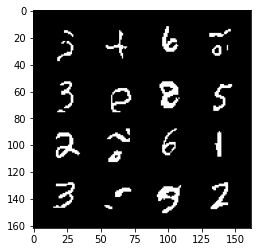

In [11]:
plt.imshow(torchvision.utils.make_grid(imglist, padding=10, nrow=4).permute((1,2,0)).cpu().detach())

In [12]:
def digit_sample(digit):
    sampl = torch.zeros( (1,1,28,28), device="cuda")
    h = nn.functional.one_hot(torch.tensor(digit),10).type(torch.float).to("cuda")
    for y in range(28):
        for x in range(28):
            params = mymodel.model(sampl, h)
            sampl[0,0,y,x] = torch.distributions.Bernoulli(logits=params[0,0,y,x]).sample()
    return sampl

In [13]:
mymodel.to("cuda")
imglist = [digit_sample(3)[0] for _ in range(16)]

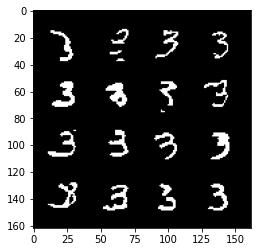

In [14]:
plt.imshow(torchvision.utils.make_grid(imglist, padding=10, nrow=4).permute((1,2,0)).cpu().detach())

In [15]:
mymodel.to("cuda")
imglist = [digit_sample(7)[0] for _ in range(16)]

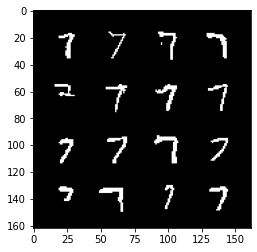

In [16]:
plt.imshow(torchvision.utils.make_grid(imglist, padding=10, nrow=4).permute((1,2,0)).cpu().detach())